<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coursework:-Baseline-Model" data-toc-modified-id="Coursework:-Baseline-Model-1">Coursework: Baseline Model</a></span><ul class="toc-item"><li><span><a href="#A.-English-German" data-toc-modified-id="A.-English-German-1.1">A. English-German</a></span><ul class="toc-item"><li><span><a href="#Importing-Data" data-toc-modified-id="Importing-Data-1.1.1">Importing Data</a></span></li><li><span><a href="#Computing-Sentence-Embeddings" data-toc-modified-id="Computing-Sentence-Embeddings-1.1.2">Computing Sentence Embeddings</a></span><ul class="toc-item"><li><span><a href="#Pre-processing-with-Spacy" data-toc-modified-id="Pre-processing-with-Spacy-1.1.2.1">Pre-processing with Spacy</a></span></li><li><span><a href="#Getting-Training-and-Validation-Sets" data-toc-modified-id="Getting-Training-and-Validation-Sets-1.1.2.2">Getting Training and Validation Sets</a></span></li></ul></li><li><span><a href="#Training-the-Regressor" data-toc-modified-id="Training-the-Regressor-1.1.3">Training the Regressor</a></span><ul class="toc-item"><li><span><a href="#SVM" data-toc-modified-id="SVM-1.1.3.1">SVM</a></span></li><li><span><a href="#Random-Tree-Forest" data-toc-modified-id="Random-Tree-Forest-1.1.3.2">Random Tree Forest</a></span></li><li><span><a href="#Neural-Net" data-toc-modified-id="Neural-Net-1.1.3.3">Neural Net</a></span></li></ul></li><li><span><a href="#Writing-Results" data-toc-modified-id="Writing-Results-1.1.4">Writing Results</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-1.1.5">Results</a></span></li><li><span><a href="#Importing-Data" data-toc-modified-id="Importing-Data-1.1.6">Importing Data</a></span></li><li><span><a href="#Computing-Sentence-Embeddings" data-toc-modified-id="Computing-Sentence-Embeddings-1.1.7">Computing Sentence Embeddings</a></span><ul class="toc-item"><li><span><a href="#Pre-processing-English-with-GloVe" data-toc-modified-id="Pre-processing-English-with-GloVe-1.1.7.1">Pre-processing English with GloVe</a></span></li><li><span><a href="#Loading-Chinese-Word2Vec-Embeddings" data-toc-modified-id="Loading-Chinese-Word2Vec-Embeddings-1.1.7.2">Loading Chinese Word2Vec Embeddings</a></span></li><li><span><a href="#Pre-processing-Chinese" data-toc-modified-id="Pre-processing-Chinese-1.1.7.3">Pre-processing Chinese</a></span></li><li><span><a href="#&quot;Working&quot;-Neural-Net" data-toc-modified-id="&quot;Working&quot;-Neural-Net-1.1.7.4">"Working" Neural Net</a></span></li></ul></li><li><span><a href="#Training-the-Regressor" data-toc-modified-id="Training-the-Regressor-1.1.8">Training the Regressor</a></span><ul class="toc-item"><li><span><a href="#SVM" data-toc-modified-id="SVM-1.1.8.1">SVM</a></span></li><li><span><a href="#Random-Tree-Forest" data-toc-modified-id="Random-Tree-Forest-1.1.8.2">Random Tree Forest</a></span></li></ul></li><li><span><a href="#Writing-Results" data-toc-modified-id="Writing-Results-1.1.9">Writing Results</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-1.1.10">Results</a></span></li></ul></li></ul></li></ul></div>

# Coursework: Baseline Model

This notebook takes you step by step to the implementation of a simple baseline model to get you started on the coursework. You have a section for the English-German task and another for English-Chinese. They are made to be standalone so feel free to check only one of the sections. However, as the tasks require slighlty different approaches, going through both sections could help you to get inspired for your chosen task, especially each task processes english in a slighlty different way.

Enjoy!

## A. English-German

### Importing Data

In [0]:
# Download and unzip the data
from os.path import exists
if not exists('ende_data.zip'):
    !wget -O ende_data.zip https://competitions.codalab.org/my/datasets/download/c748d2c0-d6be-4e36-9f12-ca0e88819c4d
    !unzip ende_data.zip

In [1]:
# Check the files
import io

#English-German
print("---EN-DE---")
print()

with open("./data/en-de/train.ende.src", "r", encoding="utf8") as ende_src:
    print("Source: ",ende_src.readline())
with open("./data/en-de/train.ende.mt", "r", encoding="utf8") as ende_mt:
    print("Translation: ",ende_mt.readline())
with open("./data/en-de/train.ende.scores", "r", encoding="utf8") as ende_scores:
    print("Score: ",ende_scores.readline())


---EN-DE---

Source:  José Ortega y Gasset visited Husserl at Freiburg in 1934.

Translation:  1934 besuchte José Ortega y Gasset Husserl in Freiburg.

Score:  1.1016968715664406



### Computing Sentence Embeddings 

For this baseline model, we will simply use pre-trained GloVe embeddings via the Spacy module and compute the vector for each word and take the global mean for each sentence. We will do the same for both source and translation sentences. For chinese tokenization and embeddings we will have to find other tools.

This is a very simplistic approach so feel free to be more creative and play around with how the sentence embeddings are computed for example ;).

GloVe embeddings do not support the Chinese language so in the section of the English-Chinese task we will have to download pretrained Chinese embeddings from word2vec repositories.

In [ ]:
#Downloading spacy models for english and german

!python -m spacy download en_core_web_md
print("en_core_web_md downloaded")
!python -m spacy link en_core_web_md en300
print("en_core_web_md linked")

!python -m spacy download de_core_news_md
print("de_core_news_md downloaded")
!python -m spacy link de_core_news_md de300
print("de_core_news_md linked")

We can now write our functions that will return the average embeddings for a sentence.

#### Pre-processing with Spacy

In [2]:
import numpy as np
import spacy
from tqdm import tqdm

from nltk import download
from nltk.corpus import stopwords

#downloading stopwords from the nltk package
download('stopwords') #stopwords dictionary, run once

stop_words_en = set(stopwords.words('english'))
stop_words_de = set(stopwords.words('german'))

def get_sentence_emb(line,nlp,lang):
    text = line.lower()
    l = [token.lemma_ for token in nlp.tokenizer(text)]
    if lang == 'en':
        l = ' '.join([word for word in l if word not in stop_words_en])
    elif lang == 'de':
        l = ' '.join([word for word in l if word not in stop_words_de])
    sen = nlp(l)
    return sen.vector

def get_embeddings(f,nlp,lang, mean=True):
    file = open(f, encoding="utf8") 
    lines = file.readlines() 
    sentences_vectors = []
    for l in tqdm(lines):
        vec = get_sentence_emb(l,nlp,lang)
        if vec is not None:
            if mean:
                vec = np.mean(vec)
            sentences_vectors.append(vec)
        else:
            print("didn't work :", l)
            sentences_vectors.append(0)

    return sentences_vectors


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gmler\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Getting Training and Validation Sets

We will now run the code fo the English-German translations and getting our training and validation sets ready for the regression task.


In [3]:
import spacy

nlp_de = spacy.load('de300')
nlp_en = spacy.load('en300')

In [4]:
import torch

#EN-DE files
de_train_src = get_embeddings("./data/en-de/train.ende.src",nlp_en,'en', mean=True)
de_train_mt = get_embeddings("./data/en-de/train.ende.mt",nlp_de,'de', mean=True)

f_train_scores = open("./data/en-de/train.ende.scores",'r')
de_train_scores = f_train_scores.readlines()

de_val_src = get_embeddings("./data/en-de/dev.ende.src",nlp_en,'en', mean=True)
de_val_mt = get_embeddings("./data/en-de/dev.ende.mt",nlp_de,'de', mean=True)

f_val_scores = open("./data/en-de/dev.ende.scores",'r')
de_val_scores = f_val_scores.readlines()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.62it/s]


In [5]:
#EN-DE
print(f"Training mt: {len(de_train_mt)} Training src: {len(de_train_src)}")
print()
print(f"Validation mt: {len(de_val_mt)} Validation src: {len(de_val_src)}")

Training mt: 7000 Training src: 7000

Validation mt: 1000 Validation src: 1000


In [7]:
#Put the features into a list
X_train = [np.array(de_train_src),np.array(de_train_mt)]
X_train_de = np.array(X_train).transpose()

X_val = [np.array(de_val_src),np.array(de_val_mt)]
X_val_de = np.array(X_val).transpose()

#Scores
train_scores = np.array(de_train_scores).astype(float)
y_train_de = train_scores

val_scores = np.array(de_val_scores).astype(float)
y_val_de = val_scores


In [0]:

# RUN IF WANT TO HAVE AVERAGE VECTOR(AND NOT GLOBAL MEAN), THIS GAVE WORSE PERFORMANCE THAN GLOBAL MEAN
'''

X_train= [np.array(train_src),np.array(train_mt)]
X_train = np.array(X_train)


X_test = [np.array(test_src),np.array(test_mt)]
X_test = np.array(X_test)


#Reshaping if using shape >3
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nx,ny*nsamples))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nx,ny*nsamples))

print(X_train.shape)
print(X_test.shape)



#Scores
train_scores = np.array(train_scores).astype(float)
y_train =train_scores

test_scores = np.array(test_scores).astype(float)
y_test =test_scores
'''


### Training the Regressor


At this point,  will try SVM and Random Tree Forests and choose the model with the highest Pearson correlation.

First we will define our RMSE function.

In [8]:
import numpy as np

def rmse(predictions, targets):
    res = np.sqrt(((predictions - targets) ** 2).mean())
    return res

#### SVM

SVM have many parameters such as the kernel and the regularizating constant C. Here we will use C = 1 and compare kernels. 

In [19]:
from sklearn.svm import SVR
from scipy.stats.stats import pearsonr

for k in ['linear','poly','rbf','sigmoid']:
    clf_t = SVR(kernel=k, gamma = 'scale')
    clf_t.fit(X_train_de, y_train_de)
    print(k)
    predictions = clf_t.predict(X_val_de)
    pearson = pearsonr(y_val_de, predictions)
    print(f'RMSE: {rmse(predictions,y_val_de)} Pearson {pearson[0]}')
    print()

linear
RMSE: 0.8813480780424763 Pearson 0.05429497493902449

poly
RMSE: 0.8812191248506788 Pearson 0.06181058128849028

rbf
RMSE: 0.8816291568820614 Pearson 0.024117081317928758

sigmoid
RMSE: 349.6488393895403 Pearson -0.036611353212000305



Here the best kernel seems to be the polynomial one as it gives us the highest pearson correlation at 0.062.

#### Random Tree Forest

Another powerful regressor is the Random Tree Forest. Here we have to choose the number of trees we want to compute and we will pick n_estimators = 1000. The higher the number the longer it will compute. To fine tune that number you could compute the error per number of trees and select the number for which there is no more significant improvement( the "elbow" of the graph).

In [13]:
# Import the model we are using

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 666)

rf.fit(X_train_de, y_train_de);


predictions = rf.predict(X_val_de)

pearson = pearsonr(y_val_de, predictions)
print('RMSE:', rmse(predictions,y_val_de))
print(f"Pearson {pearson[0]}")


RMSE: 0.9385994376085562
Pearson -0.031135023916911277


In this case, it seems like the SVM with a linear kernel performed the best on our validation set so we will save that model for the test set predictions.

#### Neural Net

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

In [19]:
import torch

#EN-DE files
de_train_src = get_embeddings("./data/en-de/train.ende.src",nlp_en,'en', mean=False)
de_train_mt = get_embeddings("./data/en-de/train.ende.mt",nlp_de,'de', mean=False)

f_train_scores = open("./data/en-de/train.ende.scores",'r')
de_train_scores = f_train_scores.readlines()

de_val_src = get_embeddings("./data/en-de/dev.ende.src",nlp_en,'en', mean=False)
de_val_mt = get_embeddings("./data/en-de/dev.ende.mt",nlp_de,'de', mean=False)
f_val_scores = open("./data/en-de/dev.ende.scores",'r')
de_val_scores = f_val_scores.readlines()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.53it/s]


In [20]:
#Put the features into a list
X_train = np.concatenate((de_train_src, de_train_mt),axis=1)
X_train_de = np.array(X_train).transpose()

X_val = np.concatenate((de_val_src,de_val_mt),axis=1)
X_val_de = np.array(X_val).transpose()

#Scores
train_scores = np.array(de_train_scores).astype(float)
y_train_de = train_scores

val_scores = np.array(de_val_scores).astype(float)
y_val_de = val_scores

In [21]:
X_train.shape # should be (7000, 600)

(7000, 600)

In [24]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, 256)  
        self.hidden2 = torch.nn.Linear(256, 64)
        self.hidden3 = torch.nn.Linear(64, 16)
        self.predict = torch.nn.Linear(16, n_output) 

    def forward(self, x):
        x = F.relu(self.hidden(x))  
        x = F.relu(self.hidden2(x))  
        x = F.relu(self.hidden3(x))  
        x = self.predict(x)
        return x

In [ ]:
net = Net(n_feature=600, n_output=1)     # define the network
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  
batch_size = 4
steps = 5000
losses = []

for t in range(steps):
    curr_bat = np.random.choice(len(X_train), batch_size, replace=False)
    x = torch.Tensor(X_train[curr_bat])
    y = torch.Tensor(y_train_de[curr_bat]).view(batch_size,-1)
    optimizer.zero_grad()
    prediction = net(x)    
    #print("prediction.shape", prediction, "y.shape", y)
    loss = loss_func(prediction, y)
    losses += [loss.item()]
    optimizer.zero_grad()   
    loss.backward()        
    optimizer.step()    
    if t % (steps // 10) == 0:
        with torch.no_grad():
            predictions = net(torch.Tensor(X_val)).flatten().data.numpy()
            pearson = pearsonr(y_val_de, predictions)
            print(f'Steps: {t} RMSE: {rmse(predictions,y_val_de)} Pearson {pearson[0]}')
plt.plot(list(range(len(losses))), losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training")
plt.yscale('log')
plt.show()

        

Steps: 0 RMSE: 0.8654182107834519 Pearson 0.08525518929193555
Steps: 500 RMSE: 0.8663918776827932 Pearson -0.02963617713214612
Steps: 1000 RMSE: 0.885829134742337 Pearson -0.011111095795974756
Steps: 1500 RMSE: 0.864803375227498 Pearson -0.014293262826311166


### Writing Results

Here is our function to write the scores into a txt file. We can follow the <Method> <ID> <SCORE> template but having only the scores will work too.

In [14]:
import os

def writeScores(method_name,scores):
    fn = "predictions.txt"
    print("")
    with open(fn, 'w') as output_file:
        for idx,x in enumerate(scores):
            #out =  metrics[idx]+":"+str("{0:.2f}".format(x))+"\n"
            #print(out)
            output_file.write(f"{x}\n")

In [20]:
#EN-DE

de_test_src = get_embeddings("./data/en-de/test.ende.src",nlp_en,'en')
de_test_mt = get_embeddings("./data/en-de/test.ende.mt",nlp_de,'de')

X= [np.array(de_test_src),np.array(de_test_mt)]
X_test = np.array(X).transpose()

#Predict
clf_de = SVR(kernel='rbf', gamma='scale')
clf_de.fit(X_train_de, y_train_de)

predictions_de = clf_de.predict(X_val_de)

In [22]:
from zipfile import ZipFile


writeScores("SVR",predictions_de)

with ZipFile("en-de_svr.zip","w") as newzip:
	newzip.write("predictions.txt")
 
#files.download('en-de_svr.zip') 

### Results

Once submitted to codalab, the pearson correlation is 0.0052.

##B. English-Chinese


### Importing Data

In [0]:
from os.path import exists

if not exists('enzh_data.zip'):
    !wget -O enzh_data.zip https://competitions.codalab.org/my/datasets/download/03e23bd7-8084-4542-997b-6a1ca6dd8a5f
    !unzip enzh_data.zip

In [0]:
#English-Chinese
#Checking Data
print("---EN-ZH---")
print()

with open("./train.enzh.src", "r") as enzh_src:
  print("Source: ",enzh_src.readline())
with open("./train.enzh.mt", "r") as enzh_mt:
  print("Translation: ",enzh_mt.readline())
with open("./train.enzh.scores", "r") as enzh_scores:
  print("Score: ",enzh_scores.readline())

### Computing Sentence Embeddings


For this task, we will compute the embeddings for words in a sentence in one language and compute the global mean for that sentence, and do the same for the other language. However, we will have to find and download pre-traind embeddings for Chinese as Spacy nor GloVe handle it. The embeddings we will be using for Chinese are of dimension 100, therefore we need to adapt the embeddings for english from the dim 300 to 100. Glove does have English embeddings of dim 100 but Spacy does not have that model. So, we will tokenize the sentences using Spacy tokenizer and use GloVe directly.

#### Pre-processing English with GloVe

With GloVe's function *stoi()* (string to int) we can get the index corresponding to a given word and with the function *itos()* we get the word given its index. To obtain the vector of a word we first get the integer associated with it and then index it into the word embedding tensor with that index. Note that glove takes words in a lower case.

In [0]:
# DON'T RUN IF YOU ALREADY RAN IT IN THE ENGLISH-GERMAN SECTION
# Downloading spacy models for english

!spacy download en_core_web_md
!spacy link en_core_web_md en300

In [5]:
import torchtext
import spacy

#Embeddings
glove = torchtext.vocab.GloVe(name='6B', dim=100)

#tokenizer model
nlp_en = spacy.load('en300')

.vector_cache\glove.6B.zip: 862MB [11:31, 1.25MB/s]                                                                    
100%|██████████████████████████████████████████████████████████████████████▉| 399380/400000 [00:20<00:00, 18465.55it/s]

We can now write our functions that will return the average embeddings for a sentence.

In [197]:
#ENGLISH EMBEDDINGS methods from the section GERMAN-ENGLISH
# The difference from previous section is that we will use Glove embeddings directly because we are using a smaller model that spacy doesn't have
# We add a method to compute the word embedding and a method to compute the sentence embedding by averaging the word vectors

import numpy as np
import torch
from nltk import download
from nltk.corpus import stopwords

#downloading stopwords from the nltk package
download('stopwords') #stopwords dictionary, run once
stop_words_en = set(stopwords.words('english'))


def preprocess(sentence,nlp):
    text = sentence.lower()
    doc = [token.lemma_ for token in  nlp.tokenizer(text)]
    doc = [word for word in doc if word not in stop_words_en]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    return doc

def get_word_vector(embeddings, word):
    try:
        vec = embeddings.vectors[embeddings.stoi[word]]
        return vec
    except KeyError:
        #print(f"Word {word} does not exist")
        pass

def get_sentence_vector(embeddings,line):
    vectors = []
    for w in line:
        emb = get_word_vector(embeddings,w)
        #do not add if the word is out of vocabulary
        if emb is not None:
            vectors.append(emb)
    return torch.mean(torch.stack(vectors), axis=0).data.numpy()


def get_embeddings(f,embeddings,lang):
    file = open(f, encoding="utf8") 
    lines = file.readlines() 
    sentences_vectors =[]

    for l in lines:
        sentence = preprocess(l,lang)
        try:
            vec = get_sentence_vector(embeddings,sentence)
            sentences_vectors.append(vec)
        except:
            sentences_vectors.append(np.zeros(100))

    return sentences_vectors


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gmler\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Loading Chinese Word2Vec Embeddings

We now have to download the pre-trained embeddings for Chinese. We will get them from the University of Oslo NLPL repository (http://vectors.nlpl.eu/repository/), which has word2vec vectors of dimension 100.

 We will also get Chinese stop words from https://github.com/Tony607/Chinese_sentiment_analysis.

For embeddings of dimensions 300 you can find them searching on github repositories. One example is https://github.com/Kyubyong/wordvectors.

If you want to work on colab and download other embeddings I would suggest you download the file and upload it on your dropbox and get the link from there.



In [126]:

!wget -c https://github.com/Tony607/Chinese_sentiment_analysis/blob/master/data/chinese_stop_words.txt

!wget -O zh.zip http://vectors.nlpl.eu/repository/20/35.zip

!unzip zh.zip 

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


We now load the pre-trained word2vec embeddings we downloaded using the gensim package. More info on gensim and how to use it to load models and embeddings here https://radimrehurek.com/gensim/models/word2vec.html

In [12]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

wv_from_bin = KeyedVectors.load_word2vec_format("data/model.bin", binary=True) 

#### Pre-processing Chinese

For pre-processing chinese sentence we will use the tokenizer package for chinese called jieba and use the downloaded list of chinese stop words to remove them from our tokens. More info on jieba and its options at https://github.com/fxsjy/jieba. 

In [198]:
import string
import jieba
import gensim 
import spacy
import numpy as np

stop_words = [line.rstrip() for line in open('data/chinese_stop_words.txt',"r", encoding="utf-8") ]

def get_sentence_vector_zh(line, mean):
    vectors = []
    for w in line:
        try:
            emb = wv_from_bin[w]
            vectors.append(emb)
        except:
            pass #Do not add if the word is out of vocabulary
    if vectors:
        vectors = np.array(vectors)
        if mean:
            vectors = np.mean(vectors) 
        else :
            vectors = np.mean(vectors, axis=0)
        return vectors
    else:
        return np.zeros(100)


def processing_zh(sentence):
    seg_list = jieba.lcut(sentence,cut_all=True)
    doc = [word for word in seg_list if word not in stop_words]
    docs = [e for e in doc if e.isalnum()]
    return docs


def get_sentence_embeddings_zh(f, mean=True):
    file = open(f, encoding="utf8") 
    lines = file.readlines() 
    sentences_vectors = []
    for l in lines:
        sent  = processing_zh(l)
        vec = get_sentence_vector_zh(sent, mean=mean)
        if vec is not None:
            sentences_vectors.append(vec)
        else:
            print(l)
    return sentences_vectors

In [199]:
import spacy
import torchtext
from torchtext import data

zh_train_mt = get_sentence_embeddings_zh("data/en-zh/train.enzh.mt", mean=False)
zh_train_src = get_embeddings("data/en-zh/train.enzh.src",glove,nlp_en)
f_train_scores = open("data/en-zh/train.enzh.scores",'r')
zh_train_scores = f_train_scores.readlines()

zh_val_src = get_embeddings("data/en-zh/dev.enzh.src",glove,nlp_en)
zh_val_mt = get_sentence_embeddings_zh("data/en-zh/dev.enzh.mt", mean=False)
f_val_scores = open("data/en-zh/dev.enzh.scores",'r')
zh_val_scores = f_val_scores.readlines()

In [157]:
print(f"Training mt: {len(zh_train_mt)} Training src: {len(zh_train_src)}")
print()
print(f"Validation mt: {len(zh_val_mt)} Validation src: {len(zh_val_src)}")

Training mt: 7000 Training src: 7000

Validation mt: 1000 Validation src: 1000


In [ ]:
"""
zh_train_src = [[x.numpy().tolist()] for x in zh_train_src]
zh_train_mt = [[x] for x in zh_train_mt]

X_train= np.concatenate((zh_train_src, zh_train_mt),axis=1)
X_train_zh = np.array(X_train).transpose()

zh_val_src = [[x.numpy().tolist()] for x in zh_val_src]
zh_val_mt = [[x] for x in zh_val_mt]

X_val = np.concatenate((zh_val_src, zh_val_mt),axis=1)
X_val_zh = np.array(X_val).transpose()

#Scores
train_scores = np.array(zh_train_scores).astype(float)
y_train_zh =train_scores

val_scores = np.array(zh_val_scores).astype(float)
y_val_zh =val_scores
"""

In [210]:
import numpy as np

X_train = np.concatenate((np.asarray(zh_train_src), np.asarray(zh_train_mt)),axis=1) #[np.array(zh_train_src),np.array(zh_train_mt)]
X_train_zh = np.array(X_train).transpose()

X_val = np.concatenate((zh_val_src, zh_val_mt),axis=1) # [np.array(zh_val_src),np.array(zh_val_mt)]
X_val_zh = np.array(X_val).transpose()

#Scores
train_scores = np.array(zh_train_scores).astype(float)
y_train_zh = train_scores

val_scores = np.array(zh_val_scores).astype(float)
y_val_zh = val_scores

#### "Working" Neural Net

In [220]:
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, 256)  
        self.hidden2 = torch.nn.Linear(256, 64)
        self.hidden3 = torch.nn.Linear(64, 16)
        self.predict = torch.nn.Linear(16, n_output) 

    def forward(self, x):
        x = F.relu(self.hidden(x))  
        x = F.relu(self.hidden2(x))  
        x = F.relu(self.hidden3(x))  
        x = self.predict(x)
        return x

In [215]:
X_train.shape

(7000, 200)

Steps: 0 RMSE: 0.927542712272044 Pearson 0.07956722932378313
Steps: 500 RMSE: 0.9081007017913342 Pearson 0.16656864469635277
Steps: 1000 RMSE: 0.9026835920917938 Pearson 0.18536981560527774
Steps: 1500 RMSE: 0.8926709650045651 Pearson 0.2095961990177902
Steps: 2000 RMSE: 0.8839960659962265 Pearson 0.24063280039165985
Steps: 2500 RMSE: 0.8781146905069215 Pearson 0.272114081515593
Steps: 3000 RMSE: 0.8688775841037109 Pearson 0.296877012921487
Steps: 3500 RMSE: 0.862833181341426 Pearson 0.31654826224688537
Steps: 4000 RMSE: 0.8636187333330465 Pearson 0.3173968184813423
Steps: 4500 RMSE: 0.8617830441639641 Pearson 0.3228217672717102


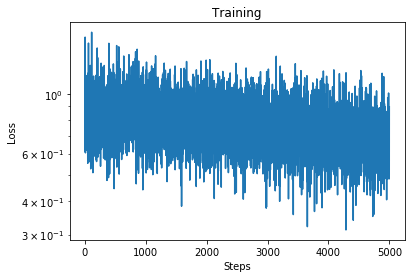

In [229]:
import matplotlib.pyplot as plt

net = Net(n_feature=200, n_output=1)     # define the network
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  
batch_size = 64
steps = 20000
losses = []

for t in range(steps):
    curr_bat = np.random.choice(len(X_train), batch_size, replace=False)
    x = torch.Tensor(X_train[curr_bat])
    y = torch.Tensor(y_train_zh[curr_bat]).view(batch_size,-1)
    optimizer.zero_grad()
    prediction = net(x)    
    #print("prediction.shape", prediction, "y.shape", y)
    loss = loss_func(prediction, y)
    losses += [loss.item()]
    optimizer.zero_grad()   
    loss.backward()        
    optimizer.step()    
    if t % (steps // 10) == 0:
        with torch.no_grad():
            predictions = net(torch.Tensor(X_val)).flatten().data.numpy()
            pearson = pearsonr(y_val_zh, predictions)
            print(f'Steps: {t} RMSE: {rmse(predictions,y_val_zh)} Pearson {pearson[0]}')
plt.plot(list(range(len(losses))), losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training")
plt.yscale('log')
plt.show()


### Training the Regressor


At this point,  will try SVM and Random Tree Forests and choose the model with the highest Pearson correlation.

First we will define our RMSE function.

In [28]:
import numpy as np

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#### SVM

SVM have many parameters such as the kernel and the regularizating constant C. Here we will use default C = 1 and compare kernels. 

In [32]:
from sklearn.svm import SVR
from scipy.stats.stats import pearsonr

for k in ['linear','poly','rbf','sigmoid']:
    clf_t = SVR(kernel=k, gamma='scale')
    clf_t.fit(X_train_zh, y_train_zh)
    print(k)
    predictions = clf_t.predict(X_val_zh)
    pearson = pearsonr(y_val_zh, predictions)
    print(f'RMSE: {rmse(predictions,y_val_zh)} Pearson {pearson[0]}')
    print()

linear
RMSE: 0.9565207295618879 Pearson 0.073132053605735

poly
RMSE: 0.9585148360226367 Pearson 0.04416178819673466

rbf
RMSE: 0.9566152315311454 Pearson 0.07900172085227566

sigmoid
RMSE: 279.96315201134644 Pearson 0.06130556970306792



In this case, the radial basis function kernel performed the best with a Pearson correlation of 0.1147. 

#### Random Tree Forest

Another powerful regressor is the Random Tree Forest. Here we have to choose the number of trees we want to compute and we will pick n_estimators = 1000. The higher the number the longer it will compute. To fine tune that number you could compute the error per number of trees and select the number for which there is no more significant improvement( the "elbow" of the graph).

In [33]:
# Import the model we are using

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 666)
rf.fit(X_train_zh, y_train_zh);
predictions = rf.predict(X_val_zh)

pearson = pearsonr(y_val_zh, predictions)
print('RMSE:', rmse(predictions,y_val_zh))
print(f"Pearson {pearson[0]}")

RMSE: 0.9768352461211436
Pearson 0.02805408709340327


Finally, we see that SVM with RBF kernel is the best model here. We will now use it to predict on the test set.

### Writing Results

In [0]:
import os

def writeScores(method_name,scores):
    fn = "predictions.txt"
    print("")
    with open(fn, 'w') as output_file:
        for idx,x in enumerate(scores):
            #out =  metrics[idx]+":"+str("{0:.2f}".format(x))+"\n"
            #print(out)
            output_file.write(f"{x}\n")
  

In [0]:
#EN_ZH

zh_test_mt = get_sentence_embeddings_zh("./test.enzh.mt")
zh_test_src = get_embeddings("./test.enzh.src",glove,nlp_en)

X= [np.array(zh_test_mt),np.array(zh_test_src)]
X_test_zh = np.array(X).transpose()

#Predict
clf_zh = SVR(kernel='rbf')
clf_zh.fit(X_train_zh, y_train_zh)

predictions_zh = clf_zh.predict(X_test_zh)


In [0]:
#EN_ZH

from google.colab import files
from zipfile import ZipFile


writeScores("SVR",predictions_zh)

with ZipFile("en-zh_svr.zip","w") as newzip:
    newzip.write("predictions.txt")
 
files.download('en-zh_svr.zip') 

### Results

Once submitted to codalab, the pearson correlation is 0.0795